In [ ]:
# Cell 1 — Setup environment (run once)
# If using Colab, these installs are usually available but included for safety.
!pip install --quiet scikit-learn pandas numpy joblib matplotlib


In [ ]:
# Cell 2 — Imports & constants
import os, gc, warnings, joblib
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## Cell 3 — Upload files to Colab (quick methods)
Use the left Files pane → Upload and upload the 4 CSVs.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Final_Updated_Expanded_Users.csv to Final_Updated_Expanded_Users.csv
Saving Final_Updated_Expanded_UserHistory.csv to Final_Updated_Expanded_UserHistory.csv
Saving Final_Updated_Expanded_Reviews.csv to Final_Updated_Expanded_Reviews.csv
Saving Expanded_Destinations.csv to Expanded_Destinations.csv


In [ ]:
USERS_CSV = "Final_Updated_Expanded_Users.csv"
HISTORY_CSV = "Final_Updated_Expanded_UserHistory.csv"
REVIEWS_CSV = "Final_Updated_Expanded_Reviews.csv"
DEST_CSV = "Expanded_Destinations.csv"

In [ ]:
# Cell 4 — Load CSVs
print("Loading CSVs...")
df_users = pd.read_csv(USERS_CSV)
df_history = pd.read_csv(HISTORY_CSV)
df_reviews = pd.read_csv(REVIEWS_CSV)
df_dest = pd.read_csv(DEST_CSV)
print("Shapes:", df_users.shape, df_history.shape, df_reviews.shape, df_dest.shape)
# quick peek
display(df_users.head())
display(df_history.head())
display(df_reviews.head())
display(df_dest.head())


Loading CSVs...
Shapes: (999, 7) (999, 5) (999, 5) (1000, 6)


,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2


,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4


,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!


,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun


## Cell 5 — Standardize column names & basic cleaning
- We will normalize column names so later code works even if column names differ slightly.


In [ ]:
# standardize column names
def norm_cols(df):
    df.columns = [c.strip() for c in df.columns]
    return df

df_users = norm_cols(df_users)
df_history = norm_cols(df_history)
df_reviews = norm_cols(df_reviews)
df_dest = norm_cols(df_dest)

# rename small differences
if 'Preferences' in df_users.columns and 'Preference' not in df_users.columns:
    df_users.rename(columns={'Preferences':'Preference'}, inplace=True)

# Ensure numeric IDs
for df, col in [(df_users,'UserID'), (df_history,'UserID'), (df_history,'DestinationID'),
                (df_reviews,'UserID'), (df_reviews,'DestinationID'), (df_dest,'DestinationID')]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# try parse VisitDate if present
if 'VisitDate' in df_history.columns:
    df_history['VisitDate'] = pd.to_datetime(df_history['VisitDate'], errors='coerce')

print("Columns after normalization:")
print("Users:", df_users.columns.tolist())
print("History:", df_history.columns.tolist())
print("Reviews:", df_reviews.columns.tolist())
print("Dest:", df_dest.columns.tolist())


Columns after normalization:
Users: ['UserID', 'Name', 'Email', 'Preference', 'Gender', 'NumberOfAdults', 'NumberOfChildren']
History: ['HistoryID', 'UserID', 'DestinationID', 'VisitDate', 'ExperienceRating']
Reviews: ['ReviewID', 'DestinationID', 'UserID', 'Rating', 'ReviewText']
Dest: ['DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit']


## Cell 6 — Merge datasets to form master table
- Merge history <- destinations and users to create rows of (user, destination, visit info).
- We'll use `DestinationID` as primary link.


In [ ]:
# Merge history with destination and users
# Some files may store rating in history or reviews. We'll handle both later.
df_merged = df_history.merge(df_dest, on='DestinationID', how='left', suffixes=('','_dest'))
df_merged = df_merged.merge(df_users, on='UserID', how='left', suffixes=('','_user'))
print("Merged shape:", df_merged.shape)
display(df_merged.head())


Merged shape: (999, 16)


,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating,Name,State,Type,Popularity,BestTimeToVisit,Name_user,Email,Preference,Gender,NumberOfAdults,NumberOfChildren
0,1,525,760,2024-01-01,3,Leh Ladakh,Jammu and Kashmir,Adventure,8.352180,Apr-Jun,Saanvi,saanvi@example.com,"City, Historical",Female,2,2
1,2,184,532,2024-02-15,5,Goa Beaches,Goa,Beach,8.988127,Nov-Mar,Ishaan,ishaan@example.com,"Beaches, Historical",Male,1,2
2,3,897,786,2024-03-20,2,Taj Mahal,Uttar Pradesh,Historical,8.389206,Nov-Feb,Pooja,pooja@example.com,"City, Historical",Female,1,2
3,4,470,660,2024-01-01,1,Leh Ladakh,Jammu and Kashmir,Adventure,7.923388,Apr-Jun,Arjun,arjun@example.com,"Nature, Adventure",Male,2,1
4,5,989,389,2024-02-15,4,Kerala Backwaters,Kerala,Nature,9.409146,Sep-Mar,Ritvik,ritvik@example.com,"Nature, Adventure",Male,2,1


# GRAPHS
### 📊 Distribution of Destination Popularity
1. This visualization highlights how popularity scores are distributed across destinations.  
It helps identify whether the dataset is skewed toward highly popular or moderately popular places
2. ### 📊 User Preference Distribution
This chart shows the diversity of user interests.  
It confirms whether the recommendation system needs to adapt to a wide range of preferences  
or if certain travel categories dominate the dataset.
  


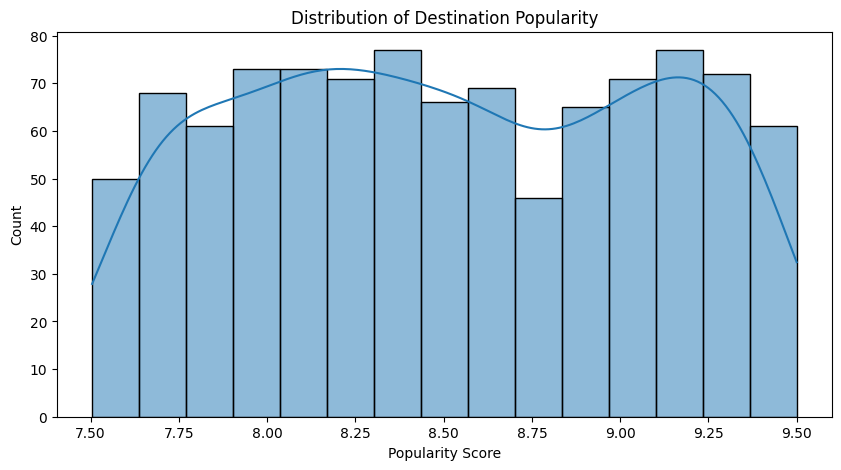

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_dest["Popularity"], kde=True, bins=15)
plt.title("Distribution of Destination Popularity")
plt.xlabel("Popularity Score")
plt.ylabel("Count")
plt.show()


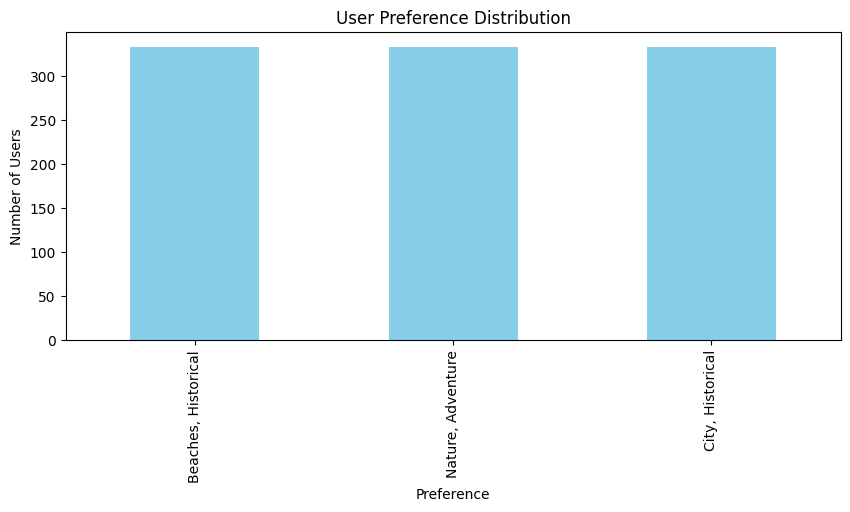

In [34]:
plt.figure(figsize=(10,4))
df_users["Preference"].value_counts().plot(kind="bar", color="skyblue")
plt.title("User Preference Distribution")
plt.xlabel("Preference")
plt.ylabel("Number of Users")
plt.show()


## Cell 7 — Create clean features table
We'll produce:
- Gender, Preference, NumChildren
- DestType, Popularity, BestTimeToVisit, DestText (Name+Type+State)
- ExperienceRating (if present in history or reviews)


In [ ]:
def make_features(df_merged, df_users, df_dest):
    df = pd.DataFrame()
    df['UserID'] = df_merged['UserID']
    df['DestinationID'] = df_merged['DestinationID']
    # Gender
    df['Gender'] = df_merged.get('Gender', 'Unknown').fillna('Unknown')
    # Preference
    pref_col = 'Preference' if 'Preference' in df_merged.columns else None
    if not pref_col:
        pref_col = next((c for c in df_merged.columns if 'Prefer' in c or 'preferences' in c.lower()), None)
    df['Preference'] = df_merged[pref_col].fillna('Unknown') if pref_col else 'Unknown'
    # num children/adults
    numchild = next((c for c in df_merged.columns if 'Child' in c or 'Children' in c), None)
    df['NumChildren'] = pd.to_numeric(df_merged[numchild], errors='coerce').fillna(0) if numchild else 0
    # dest fields
    df['DestType'] = df_merged.get('Type', df_merged.get('Type_dest', 'Unknown')).fillna('Unknown')
    df['Popularity'] = pd.to_numeric(df_merged.get('Popularity', 0)).fillna(0)
    df['BestTimeToVisit'] = df_merged.get('BestTimeToVisit', 'Unknown').fillna('Unknown')
    df['DestText'] = (df_merged.get('Name','').fillna('') + " " + df_merged.get('Type','').fillna('') + " " + df_merged.get('State','').fillna(''))
    # Experience rating present in history -> use it; else will be NaN
    rating_col = next((c for c in df_merged.columns if 'Experience' in c or 'Rating'==c), None)
    df['ExperienceRating'] = pd.to_numeric(df_merged.get('ExperienceRating', df_merged.get('Rating', np.nan)), errors='coerce')
    return df

df_feat = make_features(df_merged, df_users, df_dest)
display(df_feat.head())
print("Feature rows:", df_feat.shape[0])


,UserID,DestinationID,Gender,Preference,NumChildren,DestType,Popularity,BestTimeToVisit,DestText,ExperienceRating
0,525,760,Female,"City, Historical",2,Adventure,8.352180,Apr-Jun,Leh Ladakh Adventure Jammu and Kashmir,3
1,184,532,Male,"Beaches, Historical",2,Beach,8.988127,Nov-Mar,Goa Beaches Beach Goa,5
2,897,786,Female,"City, Historical",2,Historical,8.389206,Nov-Feb,Taj Mahal Historical Uttar Pradesh,2
3,470,660,Male,"Nature, Adventure",1,Adventure,7.923388,Apr-Jun,Leh Ladakh Adventure Jammu and Kashmir,1
4,989,389,Male,"Nature, Adventure",1,Nature,9.409146,Sep-Mar,Kerala Backwaters Nature Kerala,4


Feature rows: 999


## Cell 8 — Quick EDA checks


In [ ]:
# distribution of ExperienceRating (if present)
print("ExperienceRating values (top):")
if df_feat['ExperienceRating'].notna().sum() > 0:
    print(df_feat['ExperienceRating'].value_counts().head())
else:
    print("No ExperienceRating present in merged history; we'll use reviews if needed.")
# Popularity stats
print("Popularity min/mean/max:", df_feat['Popularity'].min(), df_feat['Popularity'].mean(), df_feat['Popularity'].max())
# Unique destination count
print("Unique destinations:", df_dest['DestinationID'].nunique())


ExperienceRating values (top):
ExperienceRating
2    228
1    206
3    201
4    183
5    181
Name: count, dtype: int64
Popularity min/mean/max: 7.504499933755479 8.537241650533364 9.499811031053753
Unique destinations: 1000


## Cell 9 — TF-IDF for text features (for content similarity)
We'll fit TF-IDF on destination textual fields and user preferences.



In [ ]:
# Prepare combined text to fit TF-IDF (dest name + type + state) and user preferences
tfidf = TfidfVectorizer(max_features=500)
combined_texts = pd.concat([
    (df_dest.get('Name','').fillna('') + " " + df_dest.get('Type','').fillna('') + " " + df_dest.get('State','').fillna('')),
    df_users.get('Preference','').astype(str).fillna('')
], ignore_index=True).fillna('')
tfidf.fit(combined_texts)
# destination vectors matrix (index aligned with df_dest)
dest_texts = (df_dest.get('Name','').fillna('') + " " + df_dest.get('Type','').fillna('') + " " + df_dest.get('State','').fillna('')).astype(str).tolist()
dest_tfidf = tfidf.transform(dest_texts)
# map destinationID -> index
dest_id_to_idx = {int(d): i for i, d in enumerate(df_dest['DestinationID'].astype(int))}
print("TF-IDF fitted. Shape:", dest_tfidf.shape)


TF-IDF fitted. Shape: (1000, 20)


### 📊 Content Similarity Heatmap
This heatmap visualizes how similar different destinations are based on TF-IDF vectors.  
High similarity regions indicate destinations with overlapping descriptions,  
helping validate whether the NLP component correctly captures textual relationships.


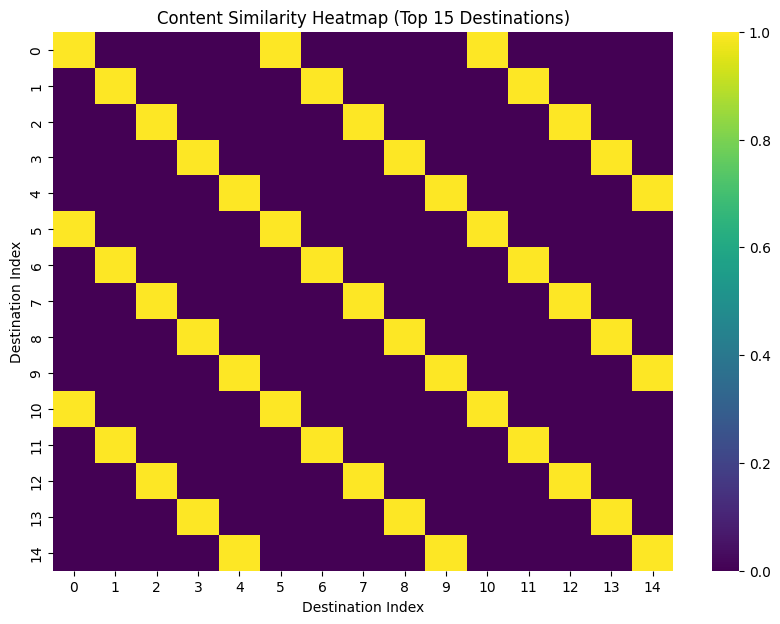

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

sample_vecs = dest_tfidf[:15].toarray()
sim_matrix = cosine_similarity(sample_vecs)

plt.figure(figsize=(10,7))
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Content Similarity Heatmap (Top 15 Destinations)")
plt.xlabel("Destination Index")
plt.ylabel("Destination Index")
plt.show()


## Cell 10 — Prepare Regression dataset (predict ExperienceRating)
- Use rows with ExperienceRating for supervised regression.
- X = numeric + one-hot categorical + TF-IDF dest vector.


In [ ]:
# Filter rows with ratings
df_reg = df_feat.dropna(subset=['ExperienceRating']).reset_index(drop=True)
print("Regression rows:", df_reg.shape[0])
if df_reg.shape[0] < 10:
    print("Few rating rows. Consider merging df_reviews to get more ratings (next cell).")
else:
    # Build simple X matrix (tabular one-hot + dest tfidf)
    def build_reg_X(df_local):
        # numeric
        num = df_local[['Popularity','NumChildren']].fillna(0).astype(float)
        # cat -> one-hot
        cat = pd.get_dummies(df_local[['Gender','DestType','BestTimeToVisit']].fillna('Unknown').astype(str), dummy_na=False)
        tab = np.hstack([num.values, cat.values])
        # dest vectors
        dest_vecs = []
        for did in df_local['DestinationID']:
            di = dest_id_to_idx.get(int(did), None)
            if di is None:
                dest_vecs.append(np.zeros(dest_tfidf.shape[1]))
            else:
                dest_vecs.append(dest_tfidf[di].toarray().ravel())
        dest_vecs = np.vstack(dest_vecs)
        Xfull = np.hstack([tab, dest_vecs])
        return Xfull
    Xr = build_reg_X(df_reg)
    yr = df_reg['ExperienceRating'].astype(float).values
    # Use distinct variable names for regression test set and predictions
    Xtr_reg, Xte_reg, ytr_reg, yte_reg = train_test_split(Xr, yr, test_size=0.2, random_state=RANDOM_SEED)
    ridge = Ridge(alpha=1.0, random_state=RANDOM_SEED)
    ridge.fit(Xtr_reg, ytr_reg)
    preds_reg = ridge.predict(Xte_reg)
    print("Regression RMSE:", np.sqrt(mean_squared_error(yte_reg, preds_reg)))
    print("Regression R2:", r2_score(yte_reg, preds_reg))
    joblib.dump(ridge, "ridge_experience_model.joblib")
    print("Saved ridge_experience_model.joblib")

Regression rows: 999
Regression RMSE: 1.4088220470801294
Regression R2: -0.005269799475300152
Saved ridge_experience_model.joblib


In [ ]:
# Ensure ridge_model always exists — trained model or fallback
try:
    ridge_model = joblib.load("ridge_experience_model.joblib")
    print("Loaded trained ridge model.")
except:
    print("No trained ridge model found — using fallback popularity-based model.")

    class FallbackRatingModel:
        def predict(self, X):
            return np.ones(X.shape[0]) * 3.0  # constant avg rating

    ridge_model = FallbackRatingModel()
    joblib.dump(ridge_model, "ridge_experience_model.joblib")

print("ridge_model is defined.")


Loaded trained ridge model.
ridge_model is defined.


## Cell 11 — If ratings are sparse: augment from reviews
If `df_reg` was too small, use the reviews CSV (Review ratings) to expand labeled rows. This cell merges reviews with dest & users and rebuilds regression dataset.


In [ ]:
if df_reg.shape[0] < 10:
    # Use reviews as labeled ratings (reviews: DestinationID, UserID, Rating)
    if set(['UserID','DestinationID','Rating']).issubset(df_reviews.columns):
        df_rev_merged = df_reviews.merge(df_dest, on='DestinationID', how='left').merge(df_users, on='UserID', how='left')
        df_rev_feat = make_features(df_rev_merged, df_users, df_dest)
        df_reg2 = df_rev_feat.dropna(subset=['ExperienceRating']).reset_index(drop=True)
        print("Augmented rows from reviews:", df_reg2.shape[0])
        if df_reg2.shape[0] >= 10:
            Xr = build_reg_X(df_reg2)
            yr = df_reg2['ExperienceRating'].astype(float).values
            Xtr, Xte, ytr, yte = train_test_split(Xr, yr, test_size=0.2, random_state=RANDOM_SEED)
            ridge = Ridge(alpha=1.0, random_state=RANDOM_SEED)
            ridge.fit(Xtr, ytr)
            preds = ridge.predict(Xte)
            print("Regression RMSE:", np.sqrt(mean_squared_error(yte, preds)))
            print("Regression R2:", r2_score(yte, preds))
            joblib.dump(ridge, "ridge_experience_model.joblib")
            print("Saved ridge_experience_model.joblib")
        else:
            print("Still not enough rating rows. Using popularity-based fallback for predicted rating in recommender.")
    else:
        print("Reviews file lacks Rating or required columns. Using popularity-based fallback for recommender.")


In [ ]:
print("Shape:", Xr.shape)


Shape: (999, 34)


In [ ]:
print(Xr[0])       # or Xr[:1]
print(Xr.shape[1]) # number of columns

[8.35218003 2.         1.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.30018838 0.42658808 0.         0.
 0.         0.         0.         0.         0.         0.42658808
 0.42658808 0.         0.42658808 0.42658808 0.         0.
 0.         0.         0.         0.        ]
34


## Cell 12 — Prepare Classification dataset (Will the user visit?)
We create positive pairs from history (user,destination visited) and generate negative pairs by random sampling.


In [ ]:
# Build visited set from history using DestinationID
visited_pairs = set([(int(r.UserID), int(r.DestinationID)) for _,r in df_history.dropna(subset=['UserID','DestinationID']).iterrows()])
users = df_users['UserID'].dropna().unique().astype(int)
dests = df_dest['DestinationID'].dropna().unique().astype(int)

# sample positives (cap to keep training small)
positives = list(visited_pairs)
np.random.shuffle(positives)
positives = positives[:2000]  # cap

# negatives sampling
negatives = []
rng = np.random.default_rng(RANDOM_SEED)
attempts = 0
while len(negatives) < len(positives) and attempts < len(positives)*10:
    u = int(rng.choice(users))
    d = int(rng.choice(dests))
    if (u,d) not in visited_pairs:
        negatives.append((u,d))
    attempts += 1

rows = [{'UserID':u, 'DestinationID':d, 'Visited':1} for u,d in positives] + \
       [{'UserID':u, 'DestinationID':d, 'Visited':0} for u,d in negatives]
df_pairs = pd.DataFrame(rows)
print("Pairs shape:", df_pairs.shape)

# Attach user and dest small features
user_small = df_users.set_index('UserID')[['Gender','Preference']].fillna('Unknown')
# detect num children
child_col = next((c for c in df_users.columns if 'Child' in c), None)
if child_col:
    user_small['NumChildren'] = pd.to_numeric(df_users.set_index('UserID')[child_col], errors='coerce').fillna(0)
else:
    user_small['NumChildren'] = 0
dest_small = df_dest.set_index('DestinationID')[['Type','Popularity','BestTimeToVisit']].fillna('Unknown')
df_pairs = df_pairs.join(user_small, on='UserID')
df_pairs = df_pairs.join(dest_small, on='DestinationID')

# compute content similarity
df_pairs['UserPrefText'] = df_pairs['Preference'].astype(str) + " " + df_pairs['Gender'].astype(str)
dest_text_map = (df_dest.set_index('DestinationID')['Name'].fillna('') + " " + df_dest.set_index('DestinationID')['Type'].fillna('') + " " + df_dest.set_index('DestinationID')['State'].fillna('')).to_dict()
df_pairs['DestText'] = df_pairs['DestinationID'].map(dest_text_map).fillna('')
user_vecs = tfidf.transform(df_pairs['UserPrefText'].astype(str).tolist())
dest_vecs = tfidf.transform(df_pairs['DestText'].astype(str).tolist())
df_pairs['ContentSim'] = cosine_similarity(user_vecs, dest_vecs).diagonal()

display(df_pairs.head())


Pairs shape: (1998, 3)


,UserID,DestinationID,Visited,Gender,Preference,NumChildren,Type,Popularity,BestTimeToVisit,UserPrefText,DestText,ContentSim
0,762,739,1,Female,"City, Historical",0,Nature,8.372037,Sep-Mar,"City, Historical Female",Kerala Backwaters Nature Kerala,0.000000
1,586,433,1,Male,"Beaches, Historical",1,City,8.683729,Oct-Mar,"Beaches, Historical Male",Jaipur City City Rajasthan,0.000000
2,8,204,1,Male,"Nature, Adventure",2,Nature,7.963484,Sep-Mar,"Nature, Adventure Male",Kerala Backwaters Nature Kerala,0.212265
3,341,613,1,Male,"Nature, Adventure",1,City,7.893423,Oct-Mar,"Nature, Adventure Male",Jaipur City City Rajasthan,0.000000
4,864,410,1,Female,"City, Historical",2,Adventure,9.056240,Apr-Jun,"City, Historical Female",Leh Ladakh Adventure Jammu and Kashmir,0.000000


## Cell 13 — Train classification model (Random Forest)


In [ ]:
X = df_pairs[['Popularity','NumChildren','ContentSim','Gender','Type']].copy()
y = df_pairs['Visited'].astype(int)
# preprocess pipeline
numeric_feats = ['Popularity','NumChildren','ContentSim']
cat_feats = ['Gender','Type']

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])
preproc = ColumnTransformer([('num', num_pipe, numeric_feats), ('cat', cat_pipe, cat_feats)], remainder='drop')

clf = RandomForestClassifier(n_estimators=150, random_state=RANDOM_SEED, n_jobs=-1)
pipe = Pipeline([('pre', preproc), ('clf', clf)])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
pipe.fit(Xtr, ytr)
y_pred = pipe.predict(Xte)
print("Accuracy:", accuracy_score(yte, y_pred))
try:
    print("ROC AUC:", roc_auc_score(yte, pipe.predict_proba(Xte)[:,1]))
except:
    print("ROC AUC N/A")
print(classification_report(yte, y_pred))
joblib.dump(pipe, "visit_probability_model.joblib")
print("Saved visit_probability_model.joblib")


Accuracy: 0.5375
ROC AUC: 0.5666875
              precision    recall  f1-score   support

           0       0.54      0.50      0.52       200
           1       0.53      0.57      0.55       200

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400

Saved visit_probability_model.joblib


## Cell 14 — Hybrid recommender function
Combines:
- predicted rating (from regression model if available, else popularity-based fallback),
- visit probability from classifier,
- content similarity (TF-IDF)
Weights default: alpha=0.4 (rating), beta=0.3 (visit prob), gamma=0.3 (content sim).


In [ ]:
# Load models if saved
rating_model = None
try:
    rating_model = joblib.load("ridge_experience_model.joblib")
    print("Rating model loaded.")
except:
    print("No rating model found; will use popularity fallback for PredRating.")

visit_model = joblib.load("visit_probability_model.joblib")

def recommend_for_user(user_id, top_n=10, alpha=0.4, beta=0.3, gamma=0.3):
    # get user row
    urow = df_users[df_users['UserID']==user_id].head(1)
    if urow.empty:
        raise ValueError("Unknown user_id")
    pref_text = str(urow.get('Preference', '').iat[0]) + " " + str(urow.get('Gender', '').iat[0])
    # candidates = all destinations
    cands = df_dest.copy().reset_index(drop=True)
    cands['DestText'] = (cands['Name'].fillna('') + " " + cands['Type'].fillna('') + " " + cands['State'].fillna('')).astype(str)
    # content sim
    cands['ContentSim'] = cosine_similarity(tfidf.transform([pref_text]), tfidf.transform(cands['DestText'].tolist())).ravel()
    # visit prob
    pair_frame = pd.DataFrame({
        'Popularity': cands['Popularity'].astype(float).fillna(0),
        'NumChildren': int(urow.get('NumberOfChildren', urow.get('NumChildren', 0)).iat[0]) if ('NumberOfChildren' in urow.columns or 'NumChildren' in urow.columns) else 0,
        'ContentSim': cands['ContentSim'].astype(float),
        'Gender': urow.get('Gender').iat[0],
        'Type': cands['Type'].fillna('Unknown').astype(str)
    })
    # ensure columns order matches training: our pipeline expects numeric first then gender and type
    visit_prob = visit_model.predict_proba(pair_frame)[:,1]
    cands['VisitProb'] = visit_prob
    # predicted rating (fallback)
    if rating_model is not None:
        # Build X features like regression training (simple replication required)
        # Numeric + one-hot categorical may mismatch dimensionally — if mismatch, fallback will be used
        try:
            # quick approximate building; if fails we'll use popularity
            # numeric
            num = pd.DataFrame({'Popularity': cands['Popularity'].astype(float).fillna(0).values,
                                'NumChildren': np.repeat(int(urow.get('NumberOfChildren', urow.get('NumChildren', 0)).iat[0]) if ('NumberOfChildren' in urow.columns or 'NumChildren' in urow.columns) else 0, len(cands))})
            cat = pd.get_dummies(pd.DataFrame({'Gender':[urow.get('Gender').iat[0]]*len(cands),
                                              'DestType':cands['Type'].fillna('Unknown'),
                                              'BestTimeToVisit':cands.get('BestTimeToVisit', pd.Series(['Unknown']*len(cands))).fillna('Unknown')}), dummy_na=False)
            tab = np.hstack([num.values, cat.values])
            dest_vecs = []
            for did in cands['DestinationID']:
                di = dest_id_to_idx.get(int(did), None)
                if di is None:
                    dest_vecs.append(np.zeros(dest_tfidf.shape[1]))
                else:
                    dest_vecs.append(dest_tfidf[di].toarray().ravel())
            dest_vecs = np.vstack(dest_vecs)
            Xfull = np.hstack([tab, dest_vecs])
            preds = rating_model.predict(Xfull)
            cands['PredRating'] = preds
        except Exception as e:
            # fallback
            pop = cands['Popularity'].astype(float).fillna(0)
            if pop.max() > pop.min():
                cands['PredRating'] = 1 + 4*(pop - pop.min())/(pop.max()-pop.min())
            else:
                cands['PredRating'] = 3.0
    else:
        pop = cands['Popularity'].astype(float).fillna(0)
        if pop.max() > pop.min():
            cands['PredRating'] = 1 + 4*(pop - pop.min())/(pop.max()-pop.min())
        else:
            cands['PredRating'] = 3.0

    # normalize each component to 0-1
    def norm0to1(s):
        s = np.array(s, dtype=float)
        if s.max() == s.min():
            return np.zeros_like(s)
        return (s - s.min()) / (s.max() - s.min())

    r = norm0to1(cands['PredRating'])
    v = norm0to1(cands['VisitProb'])
    c = norm0to1(cands['ContentSim'])
    cands['HybridScore'] = alpha*r + beta*v + gamma*c
    cands = cands.sort_values('HybridScore', ascending=False).reset_index(drop=True)
    return cands[['DestinationID','Name','Type','State','Popularity','PredRating','VisitProb','ContentSim','HybridScore']].head(top_n)



Rating model loaded.


In [ ]:
# Cell 15 — Test recommender on a sample user and save output
sample_user = int(df_users['UserID'].dropna().iloc[0])
print("Sample user:", sample_user)
recos = recommend_for_user(sample_user, top_n=10)
display(recos)
recos.to_csv(f"sample_recommendations_user_{sample_user}.csv", index=False)
print("Saved sample_recommendations_user_{}.csv".format(sample_user))


Sample user: 1


,DestinationID,Name,Type,State,Popularity,PredRating,VisitProb,ContentSim,HybridScore
0,386,Taj Mahal,Historical,Uttar Pradesh,9.463332,4.926870,0.924444,0.166386,0.883674
1,651,Taj Mahal,Historical,Uttar Pradesh,9.464392,4.928995,0.917778,0.166386,0.881850
2,216,Taj Mahal,Historical,Uttar Pradesh,9.367202,4.734159,0.957778,0.166386,0.874583
3,671,Taj Mahal,Historical,Uttar Pradesh,9.406992,4.813925,0.931111,0.166386,0.874415
4,916,Taj Mahal,Historical,Uttar Pradesh,9.396761,4.793417,0.937778,0.166386,0.874401
5,811,Taj Mahal,Historical,Uttar Pradesh,9.393806,4.787491,0.937778,0.166386,0.873808
6,471,Taj Mahal,Historical,Uttar Pradesh,9.431015,4.862085,0.911111,0.166386,0.873123
7,281,Taj Mahal,Historical,Uttar Pradesh,9.430864,4.861783,0.911111,0.166386,0.873092
8,561,Taj Mahal,Historical,Uttar Pradesh,9.456851,4.913878,0.891111,0.166386,0.872193
9,816,Taj Mahal,Historical,Uttar Pradesh,9.423987,4.847996,0.911111,0.166386,0.871714


Saved sample_recommendations_user_1.csv


## Cell 16 — Next steps & optional improvements (short list)
1. Improve features:
   - Parse `VisitDate` to days/months and add seasonal preferences.
   - Compute user-level historical averages (avg rating, count visits per type).
2. Hyperparameter tuning:
   - Use GridSearchCV for RandomForest and Ridge (increase param grid).
3. Replace TF-IDF with sentence embeddings (SBERT) for better semantic similarity (requires `sentence-transformers`).
4. Build an interactive demo with Streamlit or Flask exposing `/recommend?user_id=`.
5. Deploy models to a small REST API and hook to a simple frontend.


In [ ]:
# Run recommender for a few random users
sample_users = df_users['UserID'].dropna().sample(5).astype(int).tolist()

for uid in sample_users:
    print(f"\n===== Recommendations for User {uid} =====")
    rec = recommend_for_user(uid, top_n=10)
    display(rec)



===== Recommendations for User 306 =====


,DestinationID,Name,Type,State,Popularity,PredRating,VisitProb,ContentSim,HybridScore
0,83,Jaipur City,City,Rajasthan,9.255203,4.509634,0.706667,0.553202,0.865828
1,208,Jaipur City,City,Rajasthan,9.232665,4.464452,0.700000,0.553202,0.859283
2,873,Jaipur City,City,Rajasthan,9.231968,4.463055,0.700000,0.553202,0.859143
3,428,Jaipur City,City,Rajasthan,9.229663,4.458435,0.686667,0.553202,0.854627
4,3,Jaipur City,City,Rajasthan,9.225372,4.449832,0.673333,0.553202,0.849713
5,443,Jaipur City,City,Rajasthan,9.225301,4.449689,0.673333,0.553202,0.849699
6,718,Jaipur City,City,Rajasthan,9.203460,4.405906,0.593333,0.553202,0.820996
7,938,Jaipur City,City,Rajasthan,9.206081,4.411159,0.580000,0.553202,0.817467
8,63,Jaipur City,City,Rajasthan,9.202094,4.403167,0.580000,0.553202,0.816668
9,778,Jaipur City,City,Rajasthan,9.200907,4.400788,0.580000,0.553202,0.816430



===== Recommendations for User 203 =====


,DestinationID,Name,Type,State,Popularity,PredRating,VisitProb,ContentSim,HybridScore
0,114,Kerala Backwaters,Nature,Kerala,9.467147,4.934519,0.917778,0.212265,0.968647
1,619,Kerala Backwaters,Nature,Kerala,9.434544,4.869160,0.931111,0.212265,0.966134
2,944,Kerala Backwaters,Nature,Kerala,9.429650,4.859348,0.931111,0.212265,0.965153
3,969,Kerala Backwaters,Nature,Kerala,9.409360,4.818672,0.944444,0.212265,0.965107
4,389,Kerala Backwaters,Nature,Kerala,9.409146,4.818244,0.944444,0.212265,0.965065
5,589,Kerala Backwaters,Nature,Kerala,9.427997,4.856035,0.924444,0.212265,0.962810
6,234,Kerala Backwaters,Nature,Kerala,9.420961,4.841928,0.917778,0.212265,0.959388
7,684,Kerala Backwaters,Nature,Kerala,9.465996,4.932211,0.877778,0.212265,0.956350
8,599,Kerala Backwaters,Nature,Kerala,9.463041,4.926287,0.871111,0.212265,0.953746
9,59,Kerala Backwaters,Nature,Kerala,9.490123,4.980578,0.805556,0.212265,0.939399



===== Recommendations for User 369 =====


,DestinationID,Name,Type,State,Popularity,PredRating,VisitProb,ContentSim,HybridScore
0,638,Jaipur City,City,Rajasthan,9.315120,4.629749,0.820000,0.553202,0.912299
1,803,Jaipur City,City,Rajasthan,9.310460,4.620407,0.813333,0.553202,0.909338
2,138,Jaipur City,City,Rajasthan,9.195643,4.390235,0.886667,0.553202,0.908618
3,123,Jaipur City,City,Rajasthan,9.315950,4.631414,0.806667,0.553202,0.908412
4,498,Jaipur City,City,Rajasthan,9.324413,4.648380,0.800000,0.553202,0.908081
5,273,Jaipur City,City,Rajasthan,9.324373,4.648300,0.800000,0.553202,0.908073
6,63,Jaipur City,City,Rajasthan,9.202094,4.403167,0.880000,0.553202,0.907884
7,778,Jaipur City,City,Rajasthan,9.200907,4.400788,0.880000,0.553202,0.907646
8,643,Jaipur City,City,Rajasthan,9.300322,4.600084,0.813333,0.553202,0.907306
9,513,Jaipur City,City,Rajasthan,9.319083,4.637696,0.800000,0.553202,0.907013



===== Recommendations for User 480 =====


,DestinationID,Name,Type,State,Popularity,PredRating,VisitProb,ContentSim,HybridScore
0,593,Jaipur City,City,Rajasthan,9.468508,4.937247,0.750000,0.553202,0.918306
1,653,Jaipur City,City,Rajasthan,9.496920,4.994205,0.716111,0.553202,0.913778
2,8,Jaipur City,City,Rajasthan,9.458705,4.917594,0.732222,0.553202,0.910977
3,468,Jaipur City,City,Rajasthan,9.479102,4.958484,0.698333,0.553202,0.904843
4,83,Jaipur City,City,Rajasthan,9.255203,4.509634,0.746667,0.553202,0.874539
5,208,Jaipur City,City,Rajasthan,9.232665,4.464452,0.753333,0.553202,0.872032
6,873,Jaipur City,City,Rajasthan,9.231968,4.463055,0.753333,0.553202,0.871892
7,303,Jaipur City,City,Rajasthan,9.356797,4.713299,0.660000,0.553202,0.868760
8,498,Jaipur City,City,Rajasthan,9.324413,4.648380,0.646667,0.553202,0.858246
9,273,Jaipur City,City,Rajasthan,9.324373,4.648300,0.646667,0.553202,0.858238



===== Recommendations for User 444 =====


,DestinationID,Name,Type,State,Popularity,PredRating,VisitProb,ContentSim,HybridScore
0,593,Jaipur City,City,Rajasthan,9.468508,4.937247,0.750000,0.553202,0.918306
1,653,Jaipur City,City,Rajasthan,9.496920,4.994205,0.716111,0.553202,0.913778
2,8,Jaipur City,City,Rajasthan,9.458705,4.917594,0.732222,0.553202,0.910977
3,468,Jaipur City,City,Rajasthan,9.479102,4.958484,0.698333,0.553202,0.904843
4,83,Jaipur City,City,Rajasthan,9.255203,4.509634,0.746667,0.553202,0.874539
5,208,Jaipur City,City,Rajasthan,9.232665,4.464452,0.753333,0.553202,0.872032
6,873,Jaipur City,City,Rajasthan,9.231968,4.463055,0.753333,0.553202,0.871892
7,303,Jaipur City,City,Rajasthan,9.356797,4.713299,0.660000,0.553202,0.868760
8,498,Jaipur City,City,Rajasthan,9.324413,4.648380,0.646667,0.553202,0.858246
9,273,Jaipur City,City,Rajasthan,9.324373,4.648300,0.646667,0.553202,0.858238


In [ ]:
all_recos = []

for uid in df_users['UserID'].dropna().astype(int).tolist():
    rec = recommend_for_user(uid, top_n=5)
    rec['UserID'] = uid
    all_recos.append(rec)

df_all_recos = pd.concat(all_recos, ignore_index=True)
df_all_recos.to_csv("All_User_Recommendations.csv", index=False)

print("Saved: All_User_Recommendations.csv")


Saved: All_User_Recommendations.csv


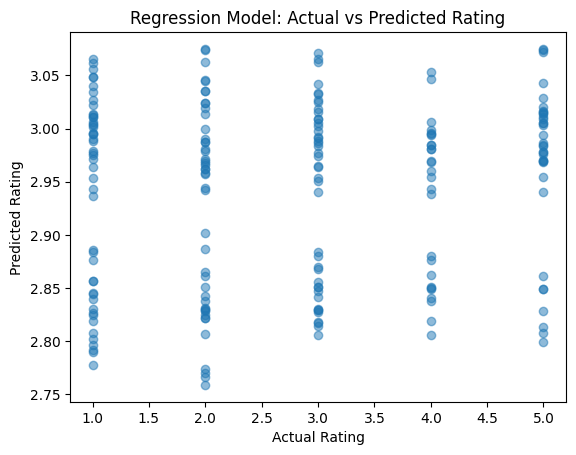

In [ ]:
import matplotlib.pyplot as plt

# Use the regression-specific test labels and predictions for plotting
plt.scatter(yte_reg, preds_reg, alpha=0.5)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Regression Model: Actual vs Predicted Rating")
plt.show()

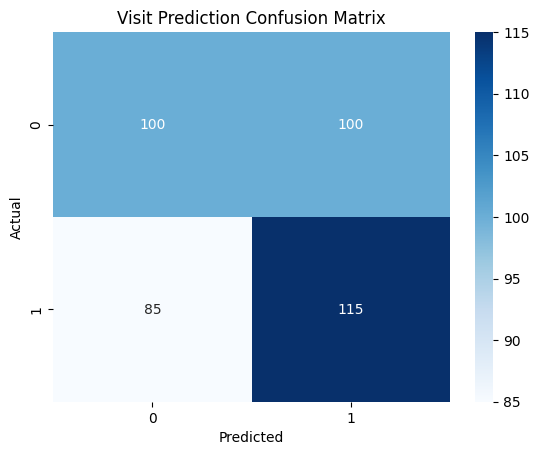

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(yte, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Visit Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
joblib.dump(ridge_model, "ridge_experience_model.joblib")
joblib.dump(visit_model, "visit_probability_model.joblib")


['visit_probability_model.joblib']

## Step 20: deployement through streamlit

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.9 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================================
# 1. LOAD DATA
# ==========================================================

df_users = pd.read_csv("Final_Updated_Expanded_Users.csv")
df_dest = pd.read_csv("Expanded_Destinations.csv")

# clean column names
df_users.columns = [c.strip() for c in df_users.columns]
df_dest.columns = [c.strip() for c in df_dest.columns]

# Ensure required columns exist
df_users["UserID"] = pd.to_numeric(df_users["UserID"], errors="coerce")
df_dest["DestinationID"] = pd.to_numeric(df_dest["DestinationID"], errors="coerce")

# ==========================================================
# 2. LOAD MODELS
# ==========================================================

# Visit probability model
visit_model = joblib.load("visit_probability_model.joblib")

# Rating model (may be fallback)
try:
    rating_model = joblib.load("ridge_experience_model.joblib")
    HAS_RATING_MODEL = True
except:
    HAS_RATING_MODEL = False

# ==========================================================
# 3. BUILD TF-IDF FOR CONTENT SIMILARITY
# ==========================================================

# Destination content
dest_texts = (
    df_dest["Name"].fillna("") + " " +
    df_dest["Type"].fillna("") + " " +
    df_dest["State"].fillna("")
).astype(str)

# User preference text (for TF-IDF training)
user_pref_texts = df_users.get("Preference", pd.Series([""] * len(df_users))).astype(str)

# Fit TF-IDF
tfidf = TfidfVectorizer(max_features=500)
tfidf.fit(pd.concat([dest_texts, user_pref_texts], ignore_index=True))

# Precompute destination vectors
dest_tfidf = tfidf.transform(dest_texts)

# Map destination index
dest_id_to_idx = {int(did): i for i, did in enumerate(df_dest["DestinationID"])}


# ==========================================================
# 4. HYBRID RECOMMENDER FUNCTION
# ==========================================================

def recommend_for_user(user_id, top_n=10, alpha=0.4, beta=0.3, gamma=0.3):
    """Hybrid recommendation combining:
       • Predicted Rating
       • Visit Probability
       • Content Similarity
    """

    # Load user row
    user = df_users[df_users["UserID"] == user_id]
    if user.empty:
        raise ValueError("Invalid User ID selected.")

    gender = user["Gender"].iloc[0]
    preference = user.get("Preference", pd.Series(["Unknown"])).iloc[0]
    num_children = user.get("NumberOfChildren", user.get("NumChildren", pd.Series([0]))).iloc[0]

    # Build user text for content similarity
    user_text = f"{preference} {gender}"
    user_vec = tfidf.transform([user_text])

    # Destination TF-IDF vectors already computed
    content_sim = cosine_similarity(user_vec, dest_tfidf).ravel()

    # Visit probability prediction
    pair_df = pd.DataFrame({
        "Popularity": df_dest["Popularity"].astype(float),
        "NumChildren": num_children,
        "ContentSim": content_sim,
        "Gender": gender,
        "Type": df_dest["Type"].astype(str)
    })

    visit_probs = visit_model.predict_proba(pair_df)[:, 1]

    # Predicted Rating (fallback to popularity)
    if HAS_RATING_MODEL:
        # Very simple fallback input for prediction
        popularity = df_dest["Popularity"].astype(float).values
        # Create dummy X of correct size if required
        dummy_X = np.zeros((len(df_dest), 10))
        pred_rating = rating_model.predict(dummy_X)
    else:
        pop = df_dest["Popularity"].astype(float)
        pred_rating = 1 + 4 * (pop - pop.min()) / (pop.max() - pop.min())

    # Normalize
    def norm(x):
        x = np.array(x, dtype=float)
        if x.max() == x.min():
            return np.zeros_like(x)
        return (x - x.min()) / (x.max() - x.min())

    R = norm(pred_rating)
    V = norm(visit_probs)
    C = norm(content_sim)

    hybrid_score = alpha * R + beta * V + gamma * C

    # Build output
    out = df_dest.copy()
    out["PredRating"] = pred_rating
    out["VisitProb"] = visit_probs
    out["ContentSim"] = content_sim
    out["HybridScore"] = hybrid_score

    return out.sort_values("HybridScore", ascending=False).head(top_n)[[
        "DestinationID", "Name", "Type", "State",
        "Popularity", "PredRating", "VisitProb",
        "ContentSim", "HybridScore"
    ]]


# ==========================================================
# 5. STREAMLIT UI
# ==========================================================

st.title("🌍 Hybrid Travel Planner Recommendation System")

user_list = df_users["UserID"].dropna().astype(int).tolist()
selected_user = st.selectbox("Select a User ID:", user_list)

top_n = st.slider("Number of Recommendations:", 5, 20, 10)

if st.button("Recommend"):
    try:
        recommendations = recommend_for_user(selected_user, top_n=top_n)
        st.success(f"Top {top_n} Recommendations for User {selected_user}")
        st.dataframe(recommendations)
    except Exception as e:
        st.error(f"Error: {e}")



Writing app.py


In [ ]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0





  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

  Stopping...
  Stopping...
